In [1]:
import pandas as pd
from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import *

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
raw = pd.read_csv("credit_card_default_analysis.csv", sep=",") 
raw.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


#### Задача 1

Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [5]:
data0 = raw.loc[raw['default'] == 0]
data1 = raw.loc[raw['default'] == 1]
raw.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

##### Данные визуально оцениваются на сходство с известными распределениями

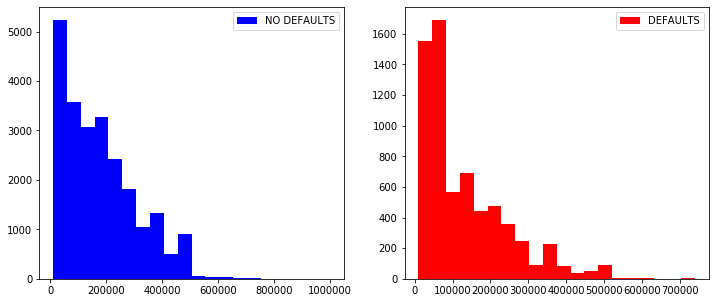

In [6]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data0['LIMIT_BAL'], bins = 20, color = 'b' , label = 'NO DEFAULTS')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data1['LIMIT_BAL'], bins = 20, color = 'r' , label = 'DEFAULTS')
pylab.legend()

pylab.show()

##### Проверка равенства медианных значений кредитного лимита с помощью подходящей интервальной оценки

###### Bootstrap

Экспериментальные данные не соответствуют широко известным распределениям, для интервальных оценок медианы используем бутстреп

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, 1000))
    #print(indices[0])
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
data0_bal = data0['LIMIT_BAL'].values
data1_bal = data1['LIMIT_BAL'].values

In [10]:
np.random.seed(0)

data0_median_bal = list(map(np.median, get_bootstrap_samples(data0_bal, 500)))
data1_median_bal = list(map(np.median, get_bootstrap_samples(data1_bal, 500)))

print("95% confidence interval for the NO DEFAULT median balance:",  stat_intervals(data0_median_bal, 0.05))
print("95% confidence interval for the DEFAULT median balance:",  stat_intervals(data1_median_bal, 0.05))

95% confidence interval for the NO DEFAULT median balance: [140000. 160000.]
95% confidence interval for the DEFAULT median balance: [ 80000. 100000.]


##### Точечная оценка разности медиан

In [11]:
print("difference between medians:", np.median(data0_bal) - np.median(data1_bal))

difference between medians: 60000.0


##### Интервальная оценка разности медиан

In [12]:
delta_median_scores = list(map(lambda x: x[0] - x[1], zip(data0_median_bal, data1_median_bal)))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

95% confidence interval for the difference between medians [50000. 80000.]


Вывод: метод bootstrap не позволяет принять гипотезу о равенстве медиан размера кредитного лимита для вернувших и не вернувших кредит.

##### Проверка гипотезы о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

Выборки для вернувших и не вернувших кредит относятся к несвязанным между собой клиентам и могут считаться независимыми. Для сравнения распределений этих выборок можно применить критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [13]:
stats.mannwhitneyu(data0['LIMIT_BAL'], data1['LIMIT_BAL'])

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Достигаемый уровень значимости pvalue проактически 0, что позволяет отвергнуть ${H_0}$ и принять гипотезу о неравенстве средних

Общий вывод: кредитный лимит заемщиков, возвращающих долг, значимо выше.

#### Задача 2

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [14]:
data0_sex = 2-data0['SEX']
data1_sex = 2-data1['SEX']

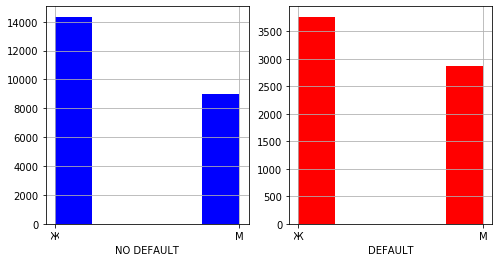

In [15]:
vals = [0,1]
labels = [ 'Ж', 'М']

pylab.figure(figsize=(8,4))

axes = pylab.subplot(1,2,1)
axes.set_xticks(vals, minor=False)
axes.set_xticklabels(labels, fontdict=None, minor=False)
pylab.grid()
pylab.hist(data0_sex, bins = 5, color = 'b')
pylab.xlabel('NO DEFAULT')

axes = pylab.subplot(1,2,2)
axes.set_xticks(vals, minor=False)
axes.set_xticklabels(labels, fontdict=None, minor=False)
pylab.grid()
pylab.hist(data1_sex, bins = 5, color = 'r')
pylab.xlabel('DEFAULT')

pylab.show()

##### Доверительный интервал для разности долей (независимые выборки)

   | $X_1$ | $X_2$  
  ------------- | -------------|
  1  | a | b 
  0  | c | d 
  $\sum$ | $n_1$| $n_2$
  
$$ \hat{p}_1 = \frac{a}{n_1}$$

$$ \hat{p}_2 = \frac{b}{n_2}$$


$$\text{Доверительный интервал для }p_1 - p_2\colon \;\; \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}}$$

In [17]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [19]:
p0 = float(sum(data0_sex)) / len(data0_sex)
p1 = float(sum(data1_sex)) / len(data1_sex)
print("Males among nodefault cases: [%f]" % p0)
print("Males among default cases: [%f]" % p1)
print("Difference: [%f]" % (p0 - p1))
print("Confidence interval: [%f, %f]" % proportions_confint_diff_ind(data0_sex, data1_sex))

Males among nodefault cases: [0.385850]
Males among default cases: [0.432942]
Difference: [-0.047092]
Confidence interval: [-0.060548, -0.033635]


Проверка с помощью доверительного интервала приводит к выводу, что доля мужчин среди отдающих кредиты значимо ниже

##### Z-критерий для разности долей (независимые выборки)

$H_0\colon p0 = p1$

$H_1\colon p0 <> p1$

In [20]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [21]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [22]:
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(data0_sex, data1_sex)))

p-value:  4.472866521609831e-12


Достигаемый уровень значимости позволяет отвергнуть гипотезу о равенстве средних. Оба метода отвергают гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит не отличается, доля мужчин среди отдающих кредиты значимо ниже.

#### Задача 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [23]:
raw.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

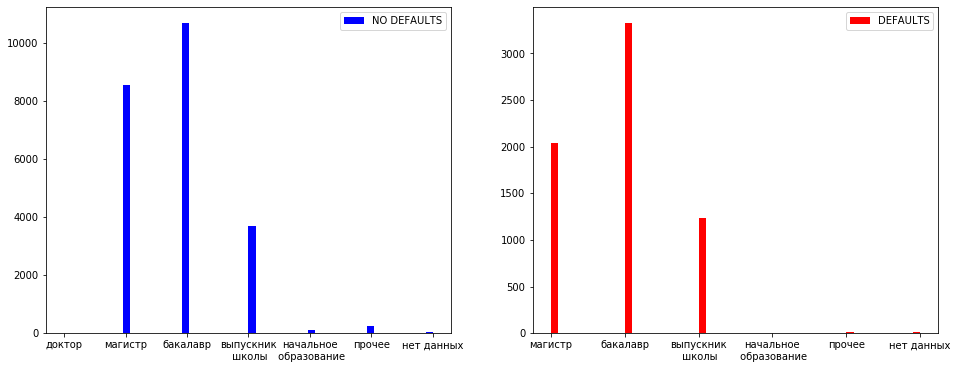

In [24]:
vals = [0,1,2,3,4,5,6]
labels = [ 'доктор', 'магистр', 'бакалавр', 'выпускник\n школы'
         , 'начальное\n образование','прочее','нет данных']

pylab.figure(figsize(16, 6))
axes = pylab.subplot(1,2,1)
axes.set_xticks(vals, minor=False)
axes.set_xticklabels(labels, fontdict=None, minor=False)
pylab.hist(data0['EDUCATION'], bins = 50, color = 'b' , label = 'NO DEFAULTS')
pylab.legend()

axes = pylab.subplot(1,2,2)
axes.set_xticks(vals, minor=False)
axes.set_xticklabels(labels, fontdict=None, minor=False)
pylab.hist(data1['EDUCATION'], bins = 50, color = 'r' , label = 'DEFAULTS')
pylab.legend()

pylab.show()

Для оценки меры взаимосвязи категориальных признаков индикатора невозврата денежных средств и уровня образования целесообразно применить коэффициент V Крамера. Для признаков вычисляется таблица сопряженности на основании которой вычисляется V и его пар-ры.

In [25]:
tab0 = data0.EDUCATION.value_counts()
tab1 = data1.EDUCATION.value_counts()
chi2_observed = np.array([[tab0[0],tab0[1],tab0[2],tab0[3],tab0[4],tab0[5],tab0[6]], [0,tab1[1],tab1[2],tab1[3],tab1[4],tab1[5],tab1[6]]])
print(chi2_observed)

[[   14  8549 10700  3680   116   262    43]
 [    0  2036  3330  1237     7    18     8]]


##### Коэффициент V Крамера

$H_0\colon {X_1} и {X_2} независимы$

$H_1\colon {H_0} неверна$

In [26]:
chi2, pval, dof, chi2_expected = chi2_contingency(chi2_observed)
print("p-value = ", pval, ", chi2 = ", chi2, ", degrees quantity = ", dof)

p-value =  1.2332626245415605e-32 , chi2 =  163.21655786997073 , degrees quantity =  6


In [27]:
vKr = (chi2/((2-1)*30000))**(1/2)
print("V Крамера value: %f" % vKr)

V Крамера value: 0.073760


Достигаемый уровень значимости позволяет отвергнуть ${H_0}$: между ${X_1}$ и ${X_2}$ имеется зависимость. При этом зависимость далека от совпадения переменных

In [28]:
chi2_delta = chi2_observed - chi2_expected
print(chi2_delta)

[[   3.0968  305.402  -226.564  -149.3596   20.2076   43.936     3.2812]
 [  -3.0968 -305.402   226.564   149.3596  -20.2076  -43.936    -3.2812]]


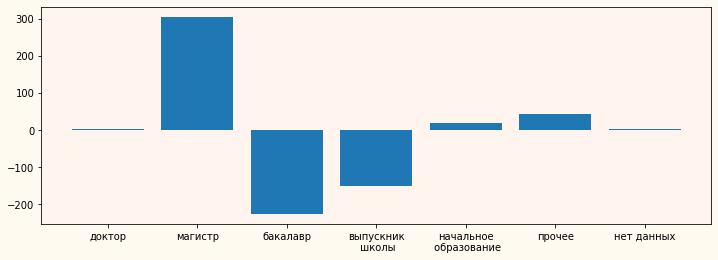

In [29]:
val = chi2_delta[0]
labels = [ 'доктор', 'магистр', 'бакалавр', 'выпускник\n школы'
         , 'начальное\n образование','прочее','нет данных']
fig, ax = plt.subplots()
ax.bar(labels, val)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)
fig.set_figheight(4)

plt.show()

Диаграмма показывает разность между наблюдаемым и ожидаемым количеством человек для отдающих долг. Вероятно, отдают долг лучше других магистры, хуже других - бакалавры и выпускники школы.

#### Задача 4

Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [30]:
raw.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

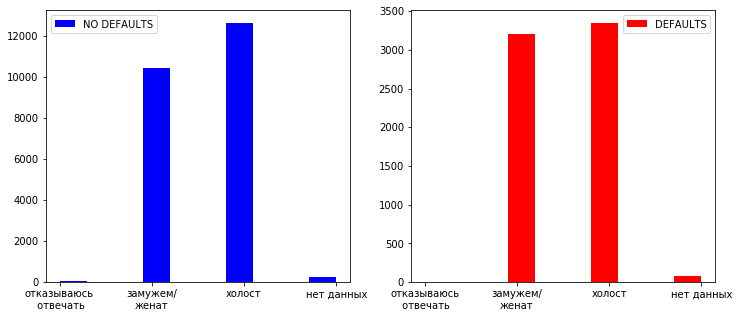

In [31]:
vals = [0,1,2,3]
labels = ['отказываюсь\n отвечать','замужем/\nженат','холост','нет данных']

pylab.figure(figsize(12, 5))
axes = pylab.subplot(1,2,1)
axes.set_xticks(vals, minor=False)
axes.set_xticklabels(labels, fontdict=None, minor=False)
pylab.hist(data0['MARRIAGE'], bins = 10, color = 'b' , label = 'NO DEFAULTS')
pylab.legend()

axes = pylab.subplot(1,2,2)
axes.set_xticks(vals, minor=False)
axes.set_xticklabels(labels, fontdict=None, minor=False)
pylab.hist(data1['MARRIAGE'], bins = 10, color = 'r' , label = 'DEFAULTS')
pylab.legend()

pylab.show()

Аналогично анализу уровня образования, применяется коэффициент V Крамера. Для признаков вычисляется таблица сопряженности на основании которой вычисляется V и его пар-ры.

In [32]:
tab0 = data0.MARRIAGE.value_counts()
tab1 = data1.MARRIAGE.value_counts()
chi2m_obsrv = np.array([[tab0[0],tab0[1],tab0[2],tab0[3]], [tab1[0],tab1[1],tab1[2],tab1[3]]])
print(chi2m_obsrv)

[[   49 10453 12623   239]
 [    5  3206  3341    84]]


##### Коэффициент V Крамера

$H_0\colon {X_1} и {X_2} независимы$

$H_1\colon {H_0} неверна$

In [33]:
chi2m, pvalm, dofm, chi2m_exp = chi2_contingency(chi2m_obsrv)
print("p-value = ", pvalm, ", chi2 = ", chi2m, ", degrees quantity = ", dofm)

p-value =  8.825862457577375e-08 , chi2 =  35.66239583433609 , degrees quantity =  3


In [34]:
vKrm = (chi2m/((2-1)*30000))**(1/2)
print("V Крамера value: %f" % vKrm)

V Крамера value: 0.034478


Достигаемый уровень значимости позволяет отвергнуть ${H_0}$ на уровне значимости 0.05: между ${X_1}$ и ${X_2}$ имеется зависимость. При этом зависимость далека от совпадения переменных

#### Задача 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

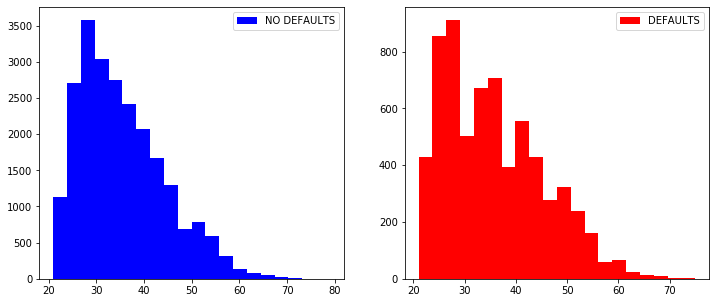

In [35]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data0['AGE'], bins = 20, color = 'b' , label = 'NO DEFAULTS')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data1['AGE'], bins = 20, color = 'r' , label = 'DEFAULTS')
pylab.legend()

pylab.show()

Визуально данные нопоминают нормальное распределение, проведем проверку нормальности с помощью Q-Q графика и методом Шапиро-Уилка

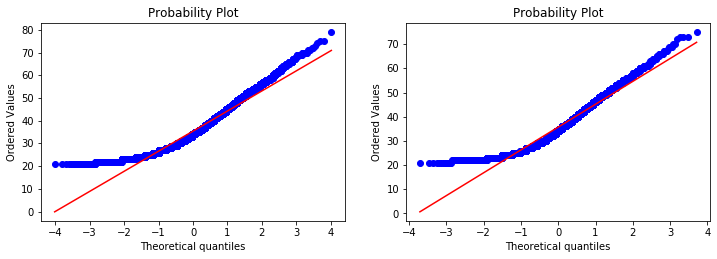

In [36]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(data0['AGE'], dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(data1['AGE'], dist="norm", plot=pylab)
pylab.show()

Критерий Шапиро-Уилка:

 $H_0\colon$ возрасты заемщиков в группе распредлены нормально
 
 $H_1\colon$ не нормально.

In [38]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data0['AGE']))

Shapiro-Wilk normality test, W-statistic: 0.949614, p-value: 0.000000


In [39]:
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(data1['AGE']))

Shapiro-Wilk normality test, W-statistic: 0.950164, p-value: 0.000000


Формально гипотеза нормальности отвергается, но линия на Q-Q графике расположена вблизи теоретически ожидаемой. 

Применим к выборкам двухвыборочный t-критерии Стьюдента для случая независимых выборок. Сравним дисперсии выборок.

In [41]:
print("Standard deviation of bigger set: ", data0['AGE'].std(), "standard deviation of smaller set: ", data1['AGE'].std())

Standard deviation of bigger set:  9.077354688665379 standard deviation of smaller set:  9.693438483999492


Дисперсии выборок несильно различаются. Также, из курса известно, что критерий Стьюдента работает в условиях, когда распределение не является нормальным, но существенно от него не отличается. Применим критерий Стьюдента для сравнения средних.

Критерий Стьюдента:

$H_0\colon$ средний возраст одинаков для заемщиков, возвращающих кредит, и для заемщиков, не возвращающих кредит.

$H_1\colon$ не одинаковы.

In [42]:
stats.ttest_ind(data0['AGE'], data1['AGE'], equal_var = False)

Ttest_indResult(statistic=-2.3195212416592628, pvalue=0.02038649025587463)

In [43]:
cm = CompareMeans(DescrStatsW(data0['AGE']), DescrStatsW(data1['AGE']))
print ("95%% confidence interval: [%f, %f]" % cm.tconfint_diff(usevar='unequal'))

95% confidence interval: [-0.569159, -0.047786]


Гипотеза ${H_0}$ отвергается на уровне значимости 0.05. Однако, результат не является достоверным, так как распределения ненормальны, а также дисперсия большей выборки немного меньше

Выборки для вернувших и не вернувших кредит относятся к несвязанным между собой клиентам и могут считаться независимыми. Для сравнения распределений этих выборок можно применить критерий Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [44]:
stats.mannwhitneyu(data0['AGE'], data1['AGE'])

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Достигаемый уровень значимости pvalue не позволяет отвергнуть гипотезу ${𝐻_0}$ на уровне значимости 0.05, таким образом, можно считать, что распределения возраста для вернувших и невернувших кредит совпадают.

Вывод: способность отдать кредит не зависит от возраста. Различия в результатах методов объясняются тем, что критерий Стьюдента применяется при пограничных для метода условиях